In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4050 Laptop GPU


In [1]:

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [5]:
import os
import pandas as pd

dataset_dir = "DATASET (SC+ST)"
chunk_size = 1_000_000

all_data = []

# Loop over files
for file_name in os.listdir(dataset_dir):
    if file_name.endswith("_100Hz") or file_name.endswith(".csv"):
        file_path = os.path.join(dataset_dir, file_name)

        # If it's not CSV yet, rename
        if file_name.endswith("_100Hz"):
            csv_path = file_path + ".csv"
            if not os.path.exists(csv_path):
                os.rename(file_path, csv_path)
            file_path = csv_path  # Update to new CSV path

        print(f"Processing: {file_path}")

        # Now read the file in chunks
        try:
            chunks = pd.read_csv(file_path, sep="\t", chunksize=chunk_size)

            for chunk in chunks:
                if {'Date', 'HH', 'MM', 'SS'}.issubset(chunk.columns):
                    # Normal case
                    chunk['timestamp'] = pd.to_datetime(
                        chunk['Date'] + " " + chunk['HH'].astype(str) + ":" + chunk['MM'].astype(str) + ":" + chunk['SS'].astype(str),
                        errors='coerce'
                    )
                    chunk['elapsed_time_sec'] = (chunk['timestamp'] - chunk['timestamp'].iloc[0]).dt.total_seconds()
                elif 'elapsed_time_sec' in chunk.columns:
                    # If already has elapsed_time_sec, use it
                    pass
                else:
                    print(f"Skipping file (missing 'Date' and 'elapsed_time_sec'): {file_name}")
                    break  # Stop processing this file

                chunk = chunk[['elapsed_time_sec', 'EEG Fpz-Cz[uV]', 'EEG Pz-Oz[uV]', 'EOG horizontal[uV]']]
                all_data.append(chunk)

        except Exception as e:
            print(f"Error while processing {file_name}: {e}")
            continue  # Move to next file

# After all files
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df.set_index('elapsed_time_sec', inplace=True)

    print(final_df.head())
    print("Shape:", final_df.shape)
else:
    print("No valid data found!")


Processing: DATASET (SC+ST)\26_F_100Hz.csv
Processing: DATASET (SC+ST)\51_F_100Hz.csv
Processing: DATASET (SC+ST)\53_F_100Hz.csv
Processing: DATASET (SC+ST)\55_M_100Hz.csv
Processing: DATASET (SC+ST)\70_M_100Hz.csv
Processing: DATASET (SC+ST)\90_M_100Hz.csv
Skipping file (missing 'Date' and 'elapsed_time_sec'): 90_M_100Hz.csv
Processing: DATASET (SC+ST)\91_F_100Hz.csv
                  EEG Fpz-Cz[uV]  EEG Pz-Oz[uV]  EOG horizontal[uV]
elapsed_time_sec                                                   
0.00                   11.492308      -1.604884          -92.886447
0.01                    7.984615       0.673016          -88.798535
0.02                    6.230769      -1.501343          -86.981685
0.03                    7.338462      -7.713797          -96.974359
0.04                    0.876923      -3.261538          -90.161172
Shape: (39750000, 3)


In [6]:
print(final_df.head())  
print(final_df.shape)





                  EEG Fpz-Cz[uV]  EEG Pz-Oz[uV]  EOG horizontal[uV]
elapsed_time_sec                                                   
0.00                   11.492308      -1.604884          -92.886447
0.01                    7.984615       0.673016          -88.798535
0.02                    6.230769      -1.501343          -86.981685
0.03                    7.338462      -7.713797          -96.974359
0.04                    0.876923      -3.261538          -90.161172
(39750000, 3)


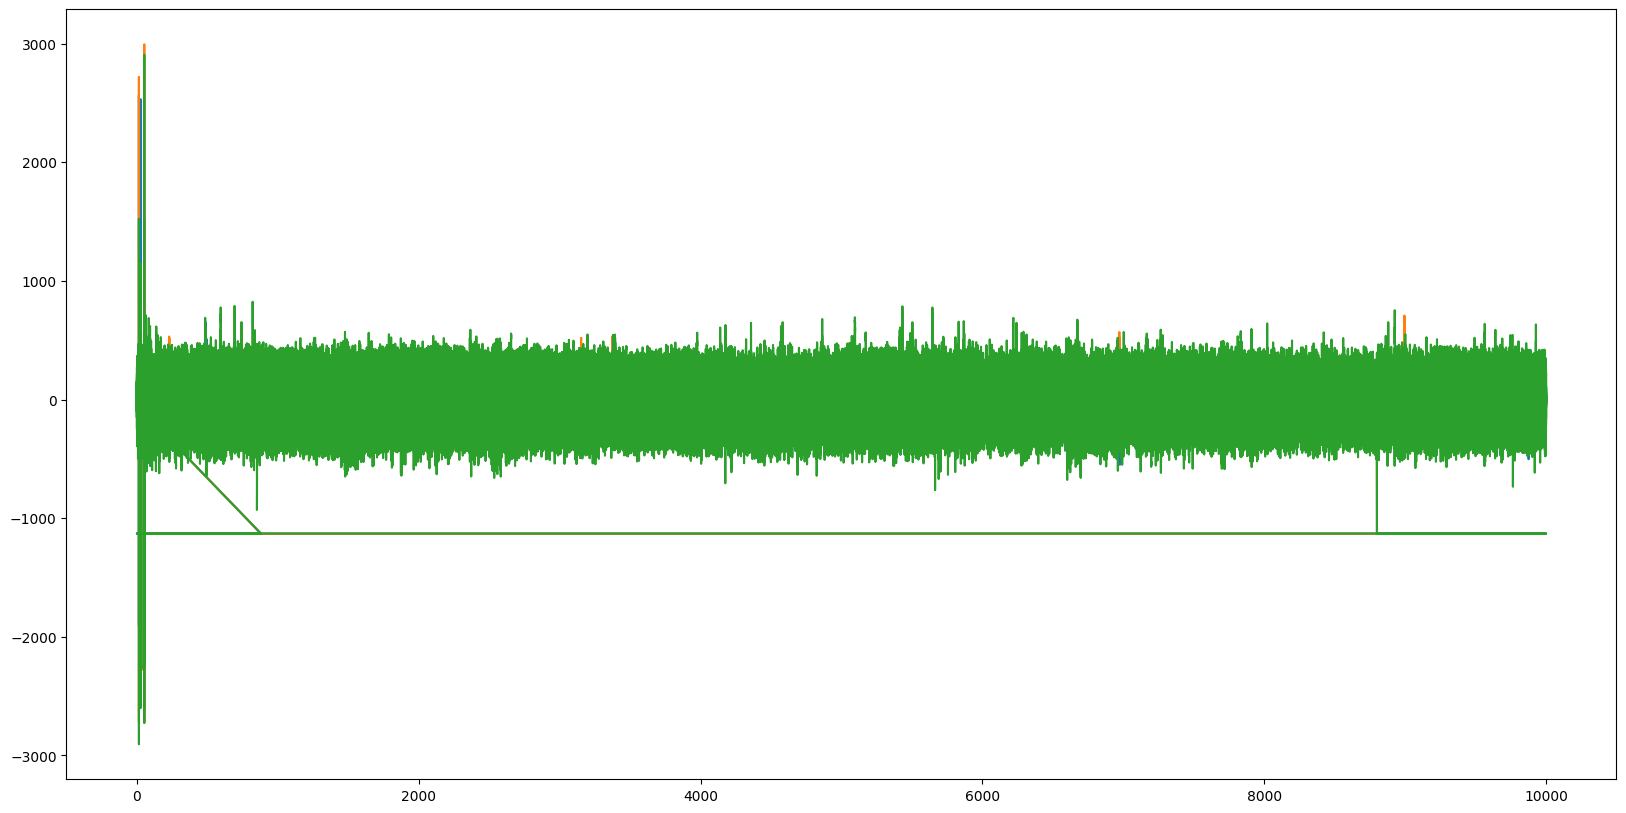

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize =(20,10))
plt.plot(final_df)
plt.show()

In [8]:
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

Rscaler = RobustScaler()
R_df = Rscaler.fit_transform(final_df)
R_df     

array([[ 0.53537622, -0.0877639 , -2.13613885],
       [ 0.38166864,  0.1019607 , -2.04043632],
       [ 0.30481485, -0.07914006, -1.99790186],
       ...,
       [-1.56137755, -0.43369402,  3.46333404],
       [-1.98089524, -0.14813082,  3.60335473],
       [-1.73229216, -0.18474149,  3.61412556]])

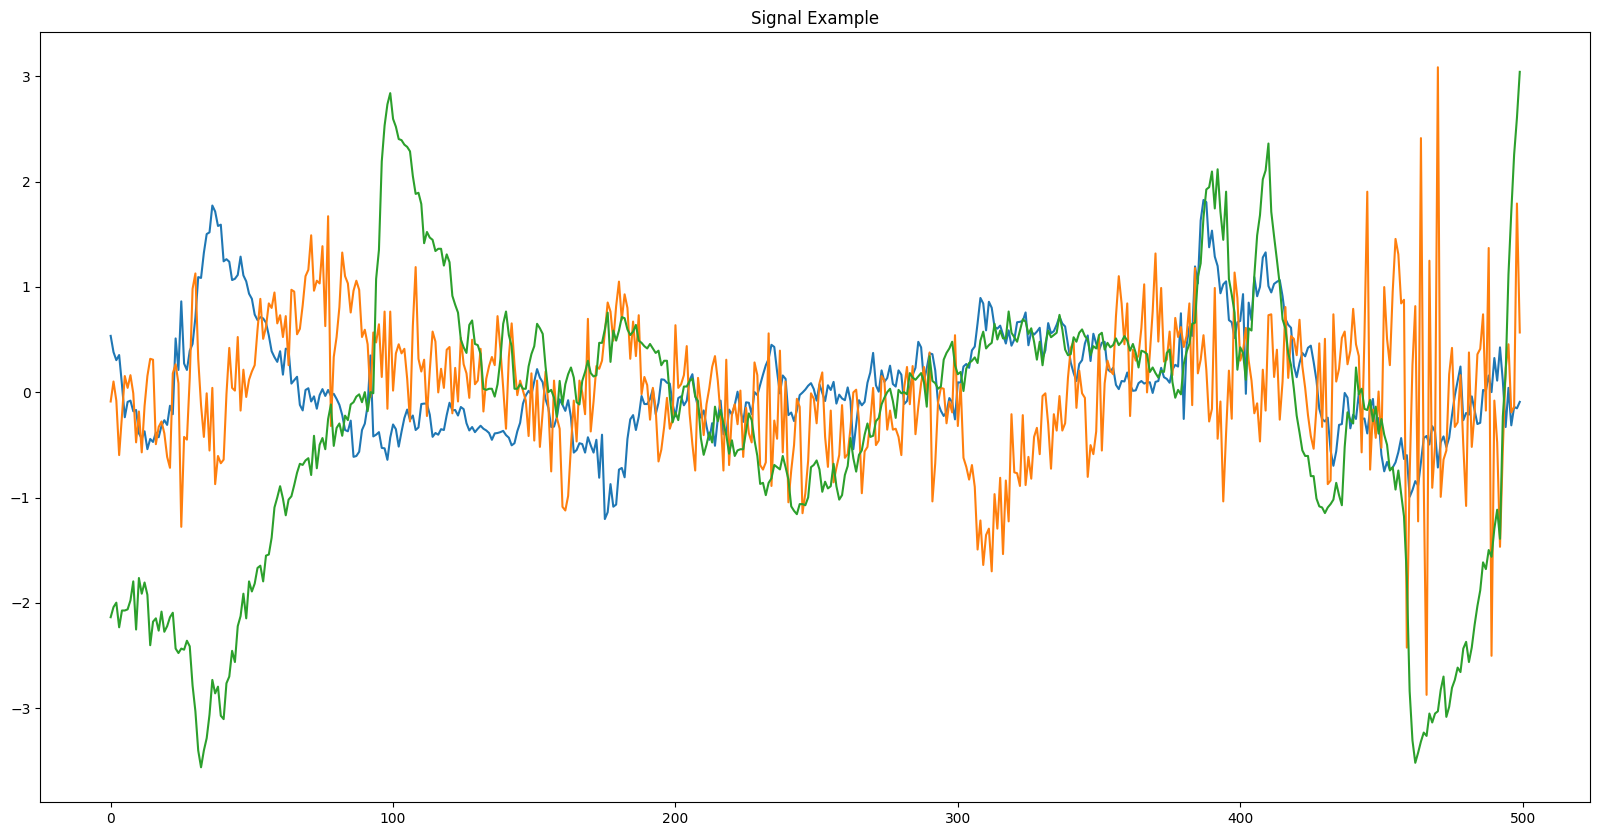

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10 ))
plt.plot(R_df[:500]) 
plt.title("Signal Example")
plt.show()

In [10]:
### WE PLOTTED THE ABOVE SIGNAL, TO CHECK FOR OUTLIERS AND EXCESSIVE ANNOMALIES. SO WE CLEAN THE OUTLIERS AND THE ANOMALIES FROM THE DATASET. 

from scipy.stats import zscore
import numpy as np
zscore = np.abs(zscore(R_df, axis = 0))
threshold = 2.5
filtered_data = np.where(zscore > threshold, np.nan, R_df)
filtered_data
df = pd.DataFrame(filtered_data, columns = ['EEG Fpz-Cz[uV]','EEG Pz-Oz[uV]','EOG horizontal[uV]'])
df
filtered_interpolated = df.interpolate(method='linear', axis=0)
filtered_interpolated = filtered_interpolated.bfill().ffill()
filtered_interpolated





,EEG Fpz-Cz[uV],EEG Pz-Oz[uV],EOG horizontal[uV]
0,0.535376,-0.087764,-2.136139
1,0.381669,0.101961,-2.040436
2,0.304815,-0.079140,-1.997902
3,0.353354,-0.596571,-2.231841
4,0.070209,-0.225745,-2.072337
...,...,...,...
39749995,-1.417654,-0.199386,2.677064
39749996,-1.223433,0.115466,3.258688
39749997,-1.561378,-0.433694,3.463334
39749998,-1.980895,-0.148131,3.603355


In [11]:
from scipy.signal import butter, filtfilt
def bandpass_filter(filtered_interpolated, lowcut=0.5, highcut=40, fs=100, order=4):
    nyq = 0.5 * fs  
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, filtered_interpolated , axis=0)
filtered_band = bandpass_filter(filtered_interpolated.values, fs=100)
dff = pd.DataFrame(filtered_band, columns = ['EEG Fpz-Cz[uV]','EEG Pz-Oz[uV]','EOG horizontal[uV]'])
dff




,EEG Fpz-Cz[uV],EEG Pz-Oz[uV],EOG horizontal[uV]
0,-0.201274,-0.187862,0.105943
1,-0.348827,0.006313,0.199621
2,-0.422637,-0.190011,0.214376
3,-0.361966,-0.699001,0.006457
4,-0.649233,-0.329789,0.098621
...,...,...,...
39749995,-0.408003,-0.004250,-0.053713
39749996,-0.083894,-0.179809,0.112704
39749997,-0.343735,-0.288422,0.479266
39749998,-0.687303,-0.257548,0.408571


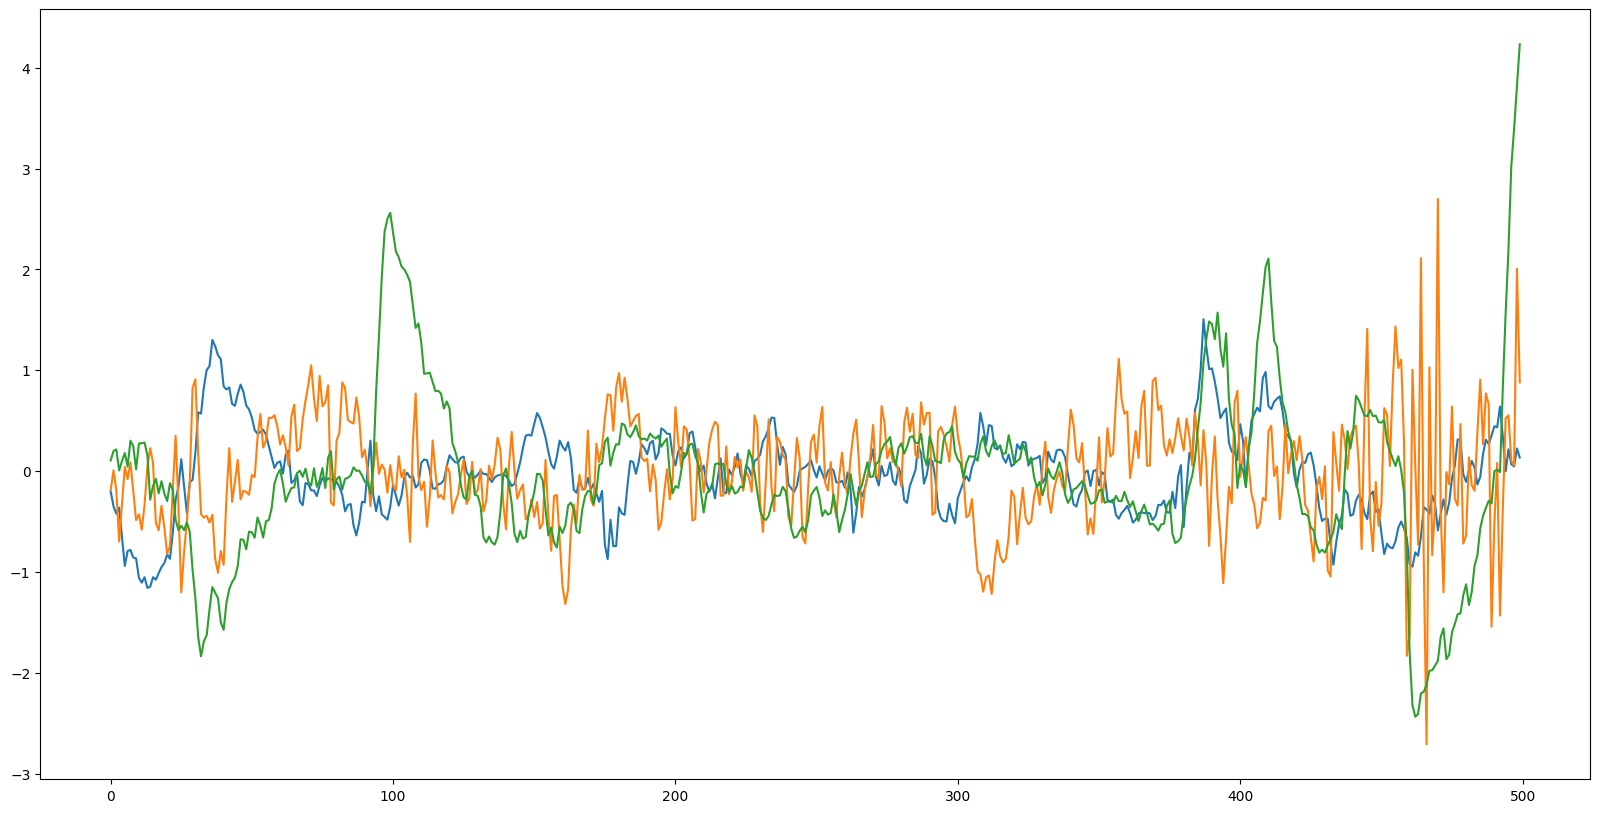

In [12]:
plt.figure(figsize = (20,10))
plt.plot(dff[:500])


In [13]:

import numpy as np
frequency = 100
window_duration = 10
frequency_window = frequency * window_duration 
signal_cols = ['EEG Fpz-Cz[uV]','EEG Pz-Oz[uV]','EOG horizontal[uV]']
signal_data = dff[signal_cols].values
n_samples = signal_data.shape[0]
n_segments = n_samples // frequency_window

trimmed_data = signal_data[:n_segments * frequency_window]
segments = trimmed_data.reshape(n_segments, frequency_window, len(signal_cols))
segments.shape[0]




39750

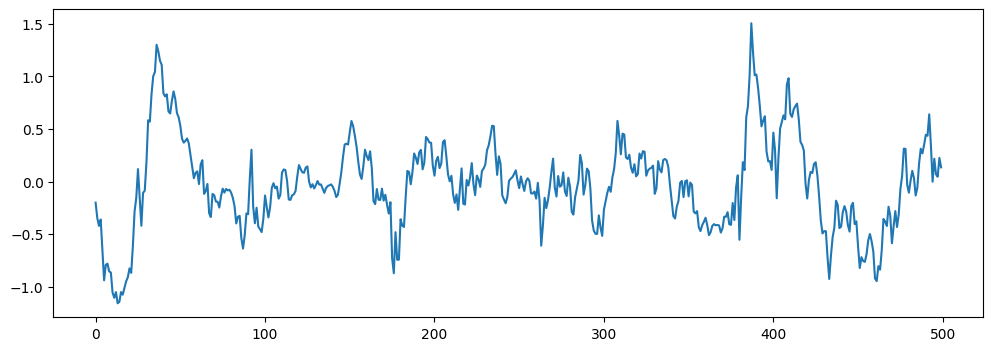

In [14]:
plt.figure(figsize = (12,4))
plt.plot(dff['EEG Fpz-Cz[uV]'][:500] )
plt.show()

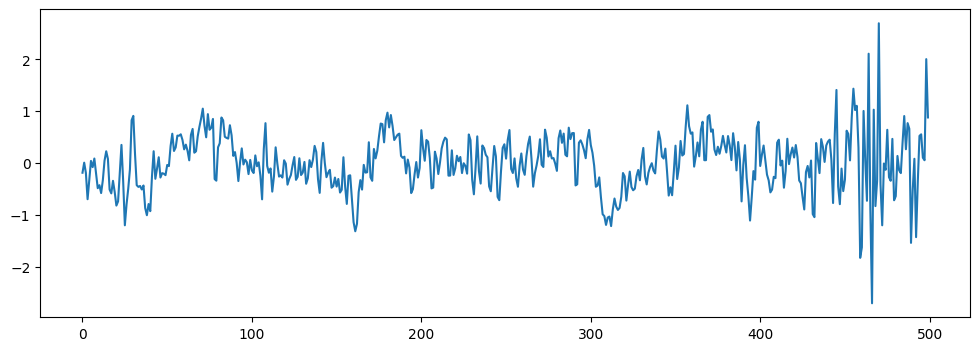

In [15]:
plt.figure(figsize = (12,4))
plt.plot(dff['EEG Pz-Oz[uV]'][:500] )
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

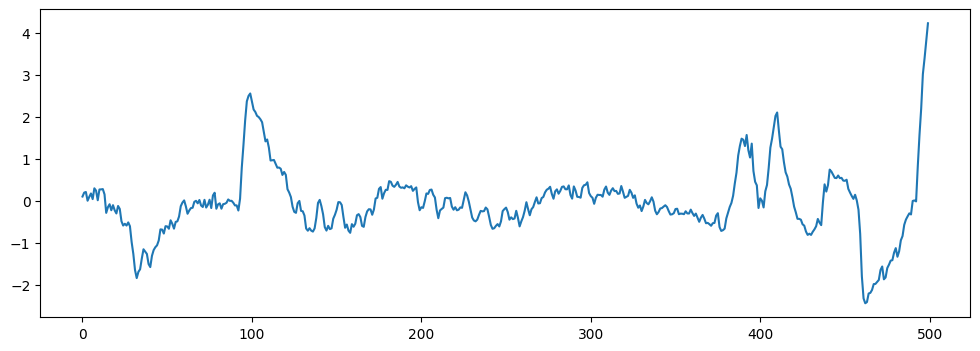

In [16]:
plt.figure(figsize = (12,4))
plt.plot(dff['EOG horizontal[uV]'][:500])
plt.show

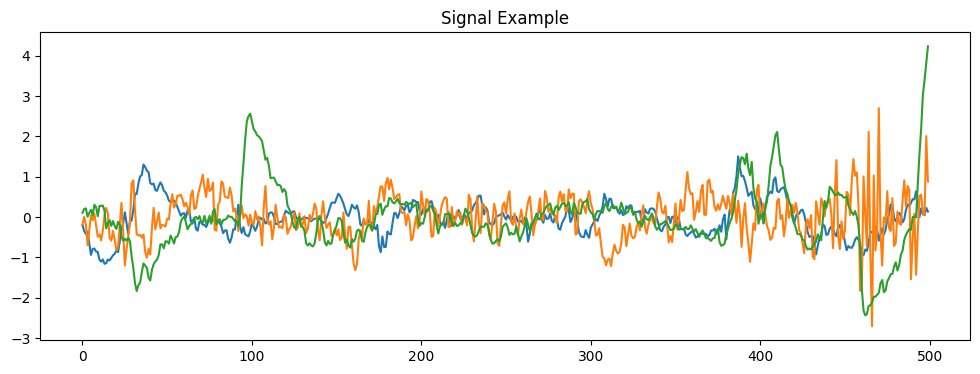

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(dff[:500]) 
plt.title("Signal Example")
plt.show()

In [18]:
variances = np.var(segments, axis = 1)
noisy_indices = np.where(variances>threshold)
noisy_indices  

labels = np.zeros(n_segments)
labels[noisy_indices[0]] = 1 

df_2= pd.DataFrame(labels, columns=['labels']) 
df_noise = df_2[df_2['labels'] == 1]
df_noise
df_clean = df_2[df_2['labels'] == 0]
df_noise




#On the basis of variances we created showed , one segment is noise and other is clean. 




,labels
16,1.0
20,1.0
21,1.0
22,1.0
24,1.0
...,...
39736,1.0
39741,1.0
39742,1.0
39743,1.0


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(segments, labels, random_state = 42, test_size = 0.2)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, frequency_window, n_features):
        super(Autoencoder, self).__init__()
        
        self.n_features = n_features
        self.frequency_window = frequency_window
        
        # Encoder (Bidirectional LSTM)
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        
        # Decoder (Bidirectional LSTM)
        self.decoder = nn.LSTM(input_size=64*2, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        
        # Output layer to map to original features (64*2 due to bidirectional LSTM)
        self.fc = nn.Linear(64*2, n_features)

    def forward(self, x):
        # Encoder forward pass
        encoded, (hn, cn) = self.encoder(x)  # Output shape: (batch_size, seq_len, 128) for bidirectional
        
        # RepeatVector equivalent: repeat encoded tensor for each time step
        encoded_repeated = encoded.repeat(1, self.frequency_window, 1)  # Shape should match (batch_size, seq_len, 128)
        
        # Decoder forward pass
        decoded, (hn, cn) = self.decoder(encoded_repeated)
        
        # Output layer to reshape the tensor to original features
        decoded = self.fc(decoded)
        return decoded

# Hyperparameters
frequency_window = 100  # Example, replace with actual value
n_features = 3         # Example, replace with actual value

# Initialize model and move it to CUDA
model = Autoencoder(frequency_window, n_features).cuda()

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Example dummy input (replace with your actual dataset)
input_data = torch.randn(32, frequency_window, n_features).cuda()  # Batch size of 32

# Forward pass example
output = model(input_data)

# Print model summary (PyTorch doesn't have model.summary() like Keras)
print(model)


Autoencoder(
  (encoder): LSTM(3, 64, batch_first=True, bidirectional=True)
  (decoder): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [21]:
dff[['EEG Fpz-Cz[uV]', 'EEG Pz-Oz[uV]', 'EOG horizontal[uV]']].describe()

,EEG Fpz-Cz[uV],EEG Pz-Oz[uV],EOG horizontal[uV]
count,3.975000e+07,3.975000e+07,3.975000e+07
mean,-9.089157e-08,-1.148135e-07,-3.530939e-07
std,8.039937e-01,8.631931e-01,1.064487e+00
min,-1.194591e+01,-1.298181e+01,-1.053620e+01
25%,-3.122142e-01,-3.828493e-01,-2.647414e-01
50%,6.629943e-13,-3.627509e-12,-1.247397e-12
75%,3.252766e-01,3.759118e-01,2.582168e-01
max,1.036786e+01,1.520749e+01,9.861665e+00


In [22]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(31800, 1000, 3)


In [23]:
print(f"Dataset length: {len(segments)}")
print(f"Original segments shape: {segments.shape}")

frequency_window = 30
n_features = 3

# First fix if segments is badly shaped
if len(segments.shape) == 3 and (segments.shape[1] != frequency_window or segments.shape[2] != n_features):
    segments = segments.reshape(-1, frequency_window, n_features)


# Now fix if segments is 2D
if len(segments.shape) == 2 and segments.shape[1] == n_features:
    total_timesteps = segments.shape[0]
    num_segments = total_timesteps // frequency_window
    segments = segments[:num_segments * frequency_window]
    segments = segments.view(segments, frequency_window, n_features)

print("Fixed segments shape:", segments.shape)  # Should be (X, 30, 3)

if not isinstance(segments, torch.Tensor):
    segments = torch.tensor(segments, dtype=torch.float32)

Dataset length: 39750
Original segments shape: (39750, 1000, 3)
Fixed segments shape: (1325000, 30, 3)


In [24]:
print(type(segments))  # Should say <class 'torch.Tensor'>
print(segments.shape)

<class 'torch.Tensor'>
torch.Size([1325000, 30, 3])


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. Assume 'segments' is already your preprocessed tensor: (1325000, 30, 3)
print(f"Segments shape: {segments.shape}")

# 2. Create TensorDataset
dataset = TensorDataset(segments, segments)  # Autoencoder: input and target are same



# 3. Split into Train, Validation, Test
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# 4. Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

# 5. Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, frequency_window, n_features):
        super(Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(input_size=64*2, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64*2, n_features)

    def forward(self, x):
        encoded, _ = self.encoder(x)              # Output: (batch_size, 30, 128)
        decoded, _ = self.decoder(encoded)         # Directly decode
        output = self.fc(decoded)                  # (batch_size, 30, 3)
        return output

# 6. Initialize model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(frequency_window=30, n_features=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 7. Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

# 8. Evaluation on Test Data
model.eval()
denoised_outputs = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        denoised_outputs.append(outputs.cpu())

# Stack all test outputs together
denoised_output = torch.cat(denoised_outputs, dim=0)

print(f"Denoised output shape: {denoised_output.shape}")


Segments shape: torch.Size([1325000, 30, 3])
Epoch 1/10 | Train Loss: 0.001365 | Val Loss: 0.000020
Epoch 2/10 | Train Loss: 0.000097 | Val Loss: 0.000014
Epoch 3/10 | Train Loss: 0.000068 | Val Loss: 0.000005
Epoch 4/10 | Train Loss: 0.000051 | Val Loss: 0.000523
Epoch 5/10 | Train Loss: 0.000043 | Val Loss: 0.000009
Epoch 6/10 | Train Loss: 0.000032 | Val Loss: 0.000006
Epoch 7/10 | Train Loss: 0.000031 | Val Loss: 0.000036
Epoch 8/10 | Train Loss: 0.000027 | Val Loss: 0.000005
Epoch 9/10 | Train Loss: 0.000023 | Val Loss: 0.000006
Epoch 10/10 | Train Loss: 0.000021 | Val Loss: 0.000002
Denoised output shape: torch.Size([132500, 30, 3])


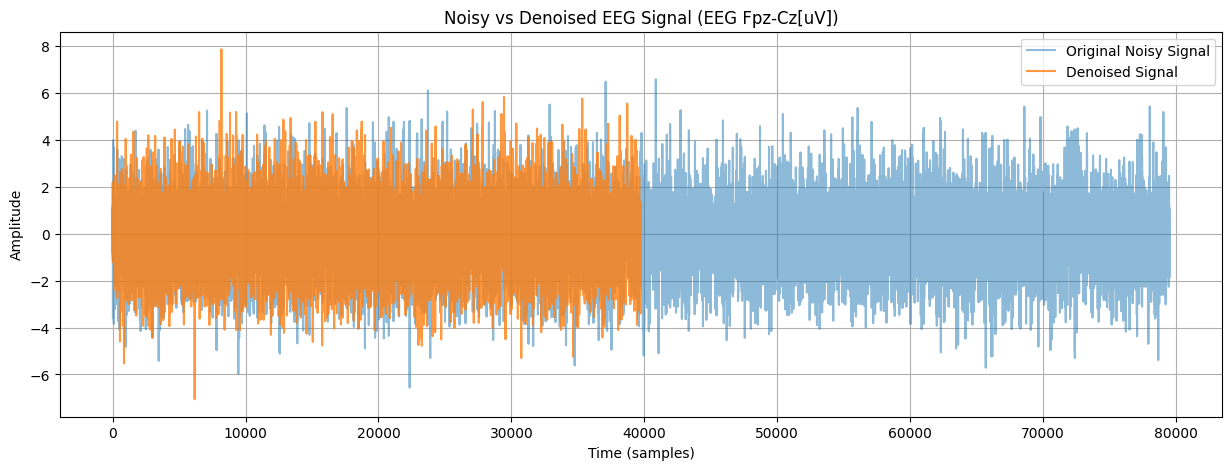

In [57]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


X_test_tensor = X_test_tensor.to(device)


model.eval()  
denoised_segments = []


with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        outputs = model(inputs)     # Get denoised outputs from the model
        denoised_segments.append(outputs.cpu())  # Move back to CPU and store


denoised_segments = torch.cat(denoised_segments, dim=0)

reconstructed_denoised_signal = denoised_segments.cpu().numpy().reshape(-1, denoised_segments.shape[-1])
reconstructed_noisy_signal = X_test_tensor.cpu().numpy().reshape(-1, X_test_tensor.shape[-1])

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))


plt.plot(reconstructed_noisy_signal[::100, 0], label='Original Noisy Signal', alpha=0.5)  # Every 100th data point
plt.plot(reconstructed_denoised_signal[::100, 0], label='Denoised Signal', alpha=0.8)

plt.title('Noisy vs Denoised EEG Signal (EEG Fpz-Cz[uV])')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')


plt.legend(loc='upper right')

plt.grid()
plt.show()


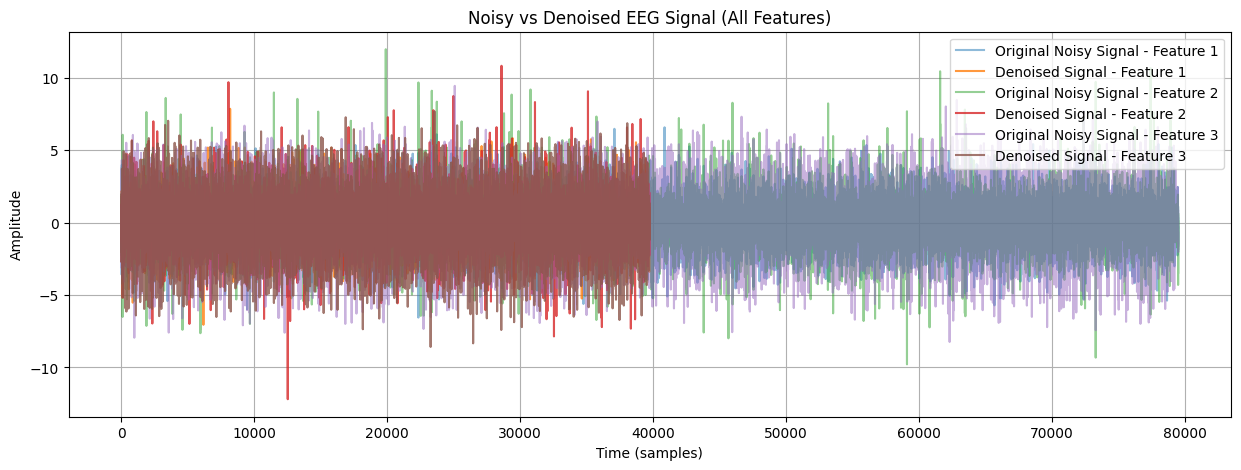

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot all three features (EEG Fpz-Cz, Channel 1, and Channel 2)
plt.plot(reconstructed_noisy_signal[::100, 0], label='Original Noisy Signal - Feature 1', alpha=0.5)
plt.plot(reconstructed_denoised_signal[::100, 0], label='Denoised Signal - Feature 1', alpha=0.8)

plt.plot(reconstructed_noisy_signal[::100, 1], label='Original Noisy Signal - Feature 2', alpha=0.5)
plt.plot(reconstructed_denoised_signal[::100, 1], label='Denoised Signal - Feature 2', alpha=0.8)

plt.plot(reconstructed_noisy_signal[::100, 2], label='Original Noisy Signal - Feature 3', alpha=0.5)
plt.plot(reconstructed_denoised_signal[::100, 2], label='Denoised Signal - Feature 3', alpha=0.8)

plt.title('Noisy vs Denoised EEG Signal (All Features)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [61]:
import numpy as np
from sklearn.metrics import precision_score, recall_score


mse_values = []
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    mse_values.append(criterion(outputs, targets).item())
average_mse = np.mean(mse_values)
print(f"Mean Squared Error (MSE) on Test Set: {average_mse:.6f}")

# 2. Calculate PSNR (Peak Signal-to-Noise Ratio) - already implemented
def psnr(target, output):
    mse_value = np.mean((target - output) ** 2)
    if mse_value == 0:
        return 100  
    max_pixel = 1.0  
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))

psnr_values = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        psnr_values.append(psnr(targets.cpu().numpy(), outputs.cpu().numpy()))

average_psnr = np.mean(psnr_values)
print(f"Peak Signal-to-Noise Ratio (PSNR) on Test Set: {average_psnr:.6f} dB")

threshold = 0.05 

accuracy_values = []
precision_values = []
recall_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

       
        target_np = targets.cpu().numpy()
        output_np = outputs.cpu().numpy()

    
        correct = np.abs(target_np - output_np) <= threshold
        accuracy_values.append(np.mean(correct))

        true_positive = correct
        false_positive = ~correct
        false_negative = ~correct

        precision = np.sum(true_positive) / (np.sum(true_positive) + np.sum(false_positive)) if np.sum(true_positive) + np.sum(false_positive) > 0 else 0
        recall = np.sum(true_positive) / (np.sum(true_positive) + np.sum(false_negative)) if np.sum(true_positive) + np.sum(false_negative) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)

# Average accuracy, precision, and recall
average_accuracy = np.mean(accuracy_values)
average_precision = np.mean(precision_values)
average_recall = np.mean(recall_values)

print(f"Accuracy on Test Set: {average_accuracy:.6f}")
print(f"Precision on Test Set: {average_precision:.6f}")
print(f"Recall on Test Set: {average_recall:.6f}")


Mean Squared Error (MSE) on Test Set: 0.000002
Peak Signal-to-Noise Ratio (PSNR) on Test Set: 58.642087 dB
Accuracy on Test Set: 0.999959
Precision on Test Set: 0.999959
Recall on Test Set: 0.999959
